# Importing Libraries

In [72]:
# General libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import dataclasses
from typing import Union, List

# Inherit from Base class
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

# Import estimators
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Import imputing features methods 
from sklearn.preprocessing import MinMaxScaler

# Import features selection methods
from sklearn.feature_selection import chi2, f_classif, SelectKBest, \
    mutual_info_classif, RFE, SelectFromModel, SequentialFeatureSelector

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from statsmodels.stats.outliers_influence import variance_inflation_factor 

# Import evaluation reports
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option('precision', 2)


# Data Acquisition

In [6]:
def load_data(path):

    data = pd.read_csv(path)

    train_data, test_data = train_test_split(data, random_state=33, test_size=0.2)
    print ('Train set shape:  ', train_data.shape)
    print ('Test set shape:   ', test_data.shape)

    return train_data, test_data

train_data, test_data = load_data("./data/heart_statlog_cleveland_hungary_final.csv")

Train set shape:   (952, 12)
Test set shape:    (238, 12)


In [7]:
train_data.head(5)

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
1024,62,1,2,120,281,0,2,103,0,1.4,2,1
562,54,1,2,132,182,0,1,141,0,0.1,1,0
998,56,1,4,125,249,1,2,144,1,1.2,2,1
241,55,1,2,145,326,0,0,155,0,0.0,1,0
640,47,1,4,112,204,0,0,143,0,0.1,1,0


# Data Preparation
- Check presence of missing values and manipulate them
- Check presence of duplicates remove them

## Missing values


In [8]:
# Remove null values if exist
print(f"--Missing values count--\n{train_data.isnull().sum().sort_values()}")

--Missing values count--
age                    0
sex                    0
chest pain type        0
resting bp s           0
cholesterol            0
fasting blood sugar    0
resting ecg            0
max heart rate         0
exercise angina        0
oldpeak                0
ST slope               0
target                 0
dtype: int64


## Duplicates

In [9]:
def remove_dup(data):
    """ Remove duplicates values if exist"""
    print(f"Duplicates count before droping:{data.duplicated().sum()}")
    data.drop_duplicates(inplace=True)
    print(f"Duplicates count after droping:{data.duplicated().sum()}")
    print(f"Data dimension{data.shape}")

remove_dup(train_data)

Duplicates count before droping:175
Duplicates count after droping:0
Data dimension(777, 12)


# Balancing
Check if the training data is well balanced because one of the major issues when dealing with unbalanced datasets relates to the metrics used to evaluate a model. Using simpler metrics like accuracy_score can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.

In [102]:
train_data['target'].value_counts().to_frame()

,target
1,422
0,355


Depending on the obtained result, the data is well balanced and no need to resample it. 

# EDA

## Features modification

### Renaming Features 
Change the features name for better readability

In [10]:
class ChangeFeaturesName(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, data):
        # Obtain features before modifying names
        self.before_ren_cols = data.columns.to_list()

        return self
        
    def transform(self, data):
        data = data.rename(
            columns={
            'resting bp s':'resting blood pressure',
            'resting ecg':'resting electrocardiographic',
            'exercise angina':'exercise induced angina',
            'oldpeak':'ST depression',
            'ST slope':'slope peak exercise ST'
        },
        )

        # Obtain features after modifying names
        self.after_ren_cols = data.columns.to_list()

        return data
        
    def get_modification(self):
        return pd.DataFrame(np.array([self.before_ren_cols, self.after_ren_cols]).T, columns=['before', 'after'])


    # return pd.DataFrame(np.array([before_ren_cols, after_ren_cols]).T, columns=['before', 'after'])

change_feat_name = ChangeFeaturesName()
train_data = change_feat_name.fit_transform(train_data)
test_data = change_feat_name.transform(test_data)

### Numbers to String
Changing categorical features that contain numbers to be in string format

| Attribute   | Updated Feature Values 
| :-- | :-- 
|**sex** |0:female<br>1:male|
|**chest_pain_type** | 1:typical angina<br>2:atypical angina<br>3:non-anginal<br>4:asymptomatic|
|**fasting_blood_sugar** |0:> 120 mg/dl<br>1:< 120 mg/dl|
|**resting_electrocardiographic** |0:normal<br>1:ST-T wave abnormality<br>2:ventricular hypertrophy|
|**exercise_induced_angina** |0:no<br>1:yes|
|**slope_peak_exercise_ST** |0:upsloping<br>1:flat<br>2:downsloping<br>3:others|
|**target** |0:no disease<br>1:disease|

In [11]:
data_w_cat_vals = train_data.copy()

data_w_cat_vals['sex'] = data_w_cat_vals['sex'].map({0:'0:female', 1:'1:male'})
data_w_cat_vals['chest pain type'] = data_w_cat_vals['chest pain type'].map({
        1:'1:typical angina', 2:'2:atypical angina',
        3:'3:non:anginal',    4:'4:asymptomatic'})
data_w_cat_vals['fasting blood sugar'] = data_w_cat_vals['fasting blood sugar'].map({
        0:'0:> 120 mg/dl', 1:'1:< 120 mg/dl'})
data_w_cat_vals['resting electrocardiographic'] = data_w_cat_vals['resting electrocardiographic'].map({
        0:'0:normal', 1:'1:ST:T wave abnormality', 2:'2:ventricular hypertrophy'})
data_w_cat_vals['exercise induced angina'] = data_w_cat_vals['exercise induced angina'].map({
        0:'0:no', 1:'1:yes'})
data_w_cat_vals['slope peak exercise ST'] = data_w_cat_vals['slope peak exercise ST'].map({
        0:'0:upsloping', 1:'1:flat', 2:'2:downsloping', 3:'3:others'})

data_w_cat_vals['target'] = data_w_cat_vals['target'].map({0:'0:no disease', 1:'1:disease'})

data_w_cat_vals.head(5)


,age,sex,chest pain type,resting blood pressure,cholesterol,fasting blood sugar,resting electrocardiographic,max heart rate,exercise induced angina,ST depression,slope peak exercise ST,target
1024,62,1:male,2:atypical angina,120,281,0:> 120 mg/dl,2:ventricular hypertrophy,103,0:no,1.4,2:downsloping,1:disease
562,54,1:male,2:atypical angina,132,182,0:> 120 mg/dl,1:ST:T wave abnormality,141,0:no,0.1,1:flat,0:no disease
998,56,1:male,4:asymptomatic,125,249,1:< 120 mg/dl,2:ventricular hypertrophy,144,1:yes,1.2,2:downsloping,1:disease
241,55,1:male,2:atypical angina,145,326,0:> 120 mg/dl,0:normal,155,0:no,0.0,1:flat,0:no disease
640,47,1:male,4:asymptomatic,112,204,0:> 120 mg/dl,0:normal,143,0:no,0.1,1:flat,0:no disease


In [12]:
cat_cols = data_w_cat_vals.select_dtypes('object').columns.to_list()
num_cols = data_w_cat_vals.select_dtypes(np.number).columns.to_list()

## Data description

### Data type

In [13]:
data_w_cat_vals.dtypes

age                               int64
sex                              object
chest pain type                  object
resting blood pressure            int64
cholesterol                       int64
fasting blood sugar              object
resting electrocardiographic     object
max heart rate                    int64
exercise induced angina          object
ST depression                   float64
slope peak exercise ST           object
target                           object
dtype: object

### Statistical analysis

#### Categorical data

In [14]:
data_w_cat_vals.describe(include='object')

,sex,chest pain type,fasting blood sugar,resting electrocardiographic,exercise induced angina,slope peak exercise ST,target
count,777,777,777,777,777,777,777
unique,2,4,2,3,2,4,2
top,1:male,4:asymptomatic,0:> 120 mg/dl,0:normal,0:no,2:downsloping,1:disease
freq,609,410,602,462,464,388,422


#### Numeric data 

In [15]:
data_w_cat_vals.describe(include=np.number)

,age,resting blood pressure,cholesterol,max heart rate,ST depression
count,777.00,777.00,777.00,777.00,777.00
mean,53.57,132.25,201.79,137.46,0.90
std,9.40,18.49,105.66,25.76,1.06
min,28.00,0.00,0.00,60.00,-2.60
25%,47.00,120.00,178.00,120.00,0.00
50%,54.00,130.00,224.00,139.00,0.60
75%,60.00,140.00,269.00,157.00,1.50
max,77.00,200.00,564.00,202.00,6.20


## Plotting

### Plot - categorical features

In [14]:
cat_data = data_w_cat_vals[cat_cols]

cat_data = pd.concat([cat_data, train_data['age']], axis=1)

cat_disease = cat_data[cat_data['target'] == '1:disease']
cat_no_disease = cat_data[cat_data['target'] == '0:no disease']

desired_data = {
    0: {"title":"DISEASE, target = 1", "data":cat_disease},
    1: {"title":"NO DISEASE, target = 0", "data":cat_no_disease},
    2: {"title":"Overall - {}", "data":cat_data},
}


#### Plotting - Swarm

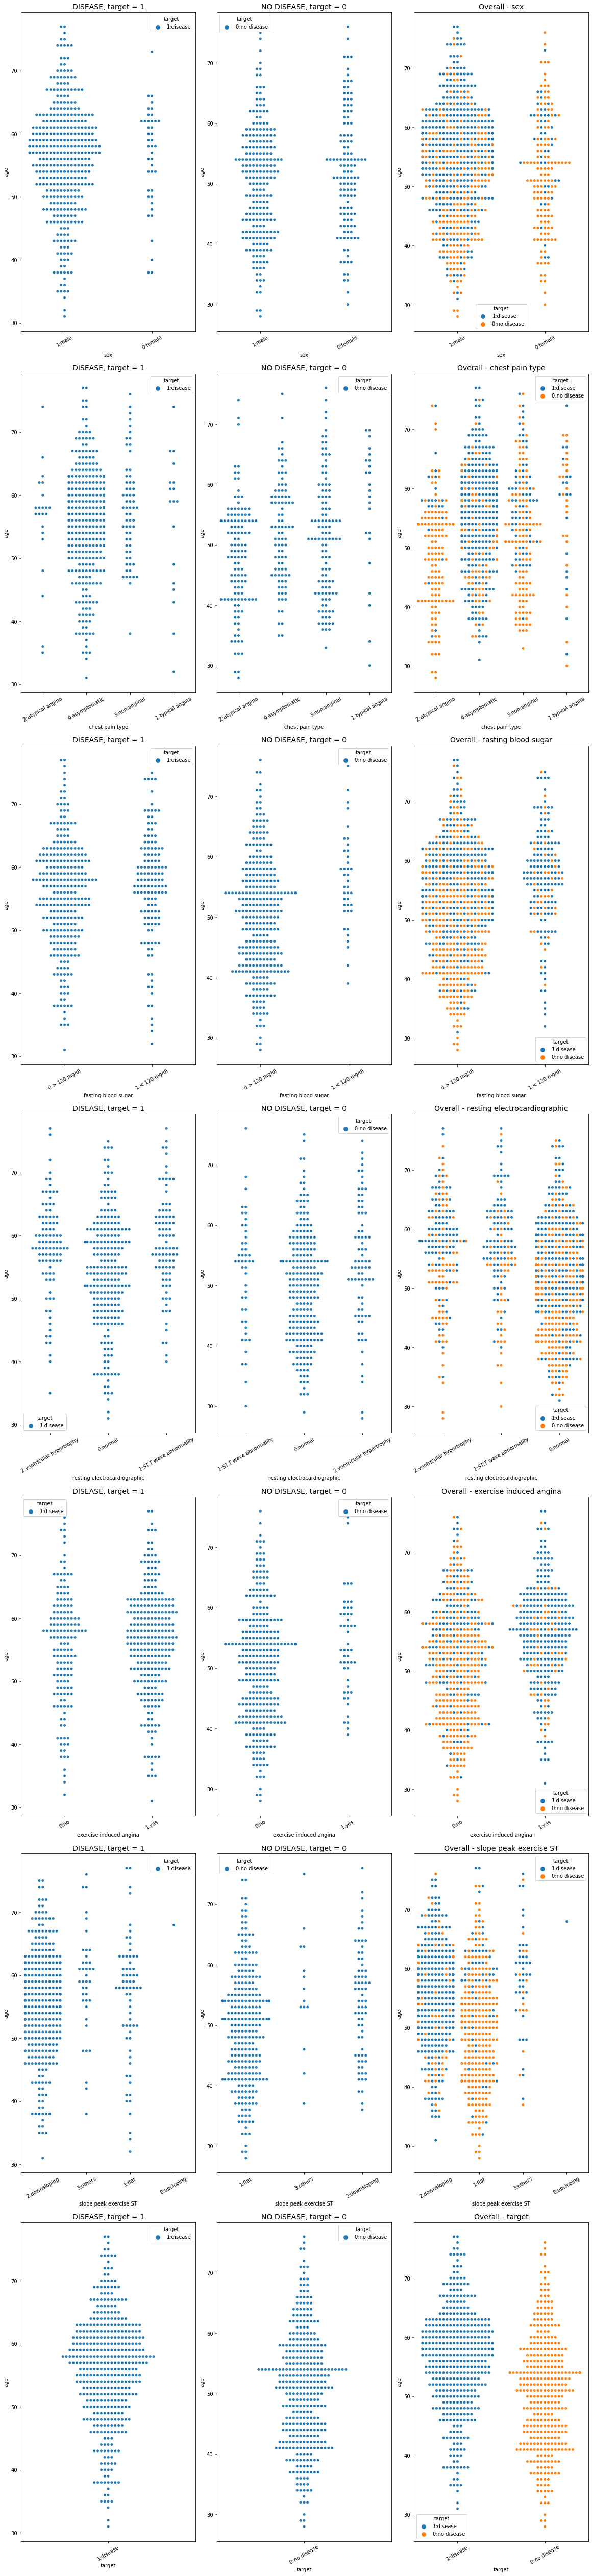

In [15]:
def plot_swarm_var():
    sub_num_of_row = len(cat_cols)
    sub_num_of_col = 3     # three columns: overall, no disease, disease

    _, axs = plt.subplots(nrows=sub_num_of_row, ncols=sub_num_of_col, figsize=(16, 70), constrained_layout = True)


    for i in range(sub_num_of_row):
        for j in range(sub_num_of_col):
            graph = sns.swarmplot(data=desired_data[j].get('data'), x=cat_cols[i], y='age', hue='target', ax=axs[i][j])
            graph.set_title(desired_data[j].get('title').format(cat_cols[i]), fontsize=14)
            graph.set_xticklabels(labels=graph.get_xticklabels(), rotation=30)

plot_swarm_var()

#### Plotting - Count/Swarm

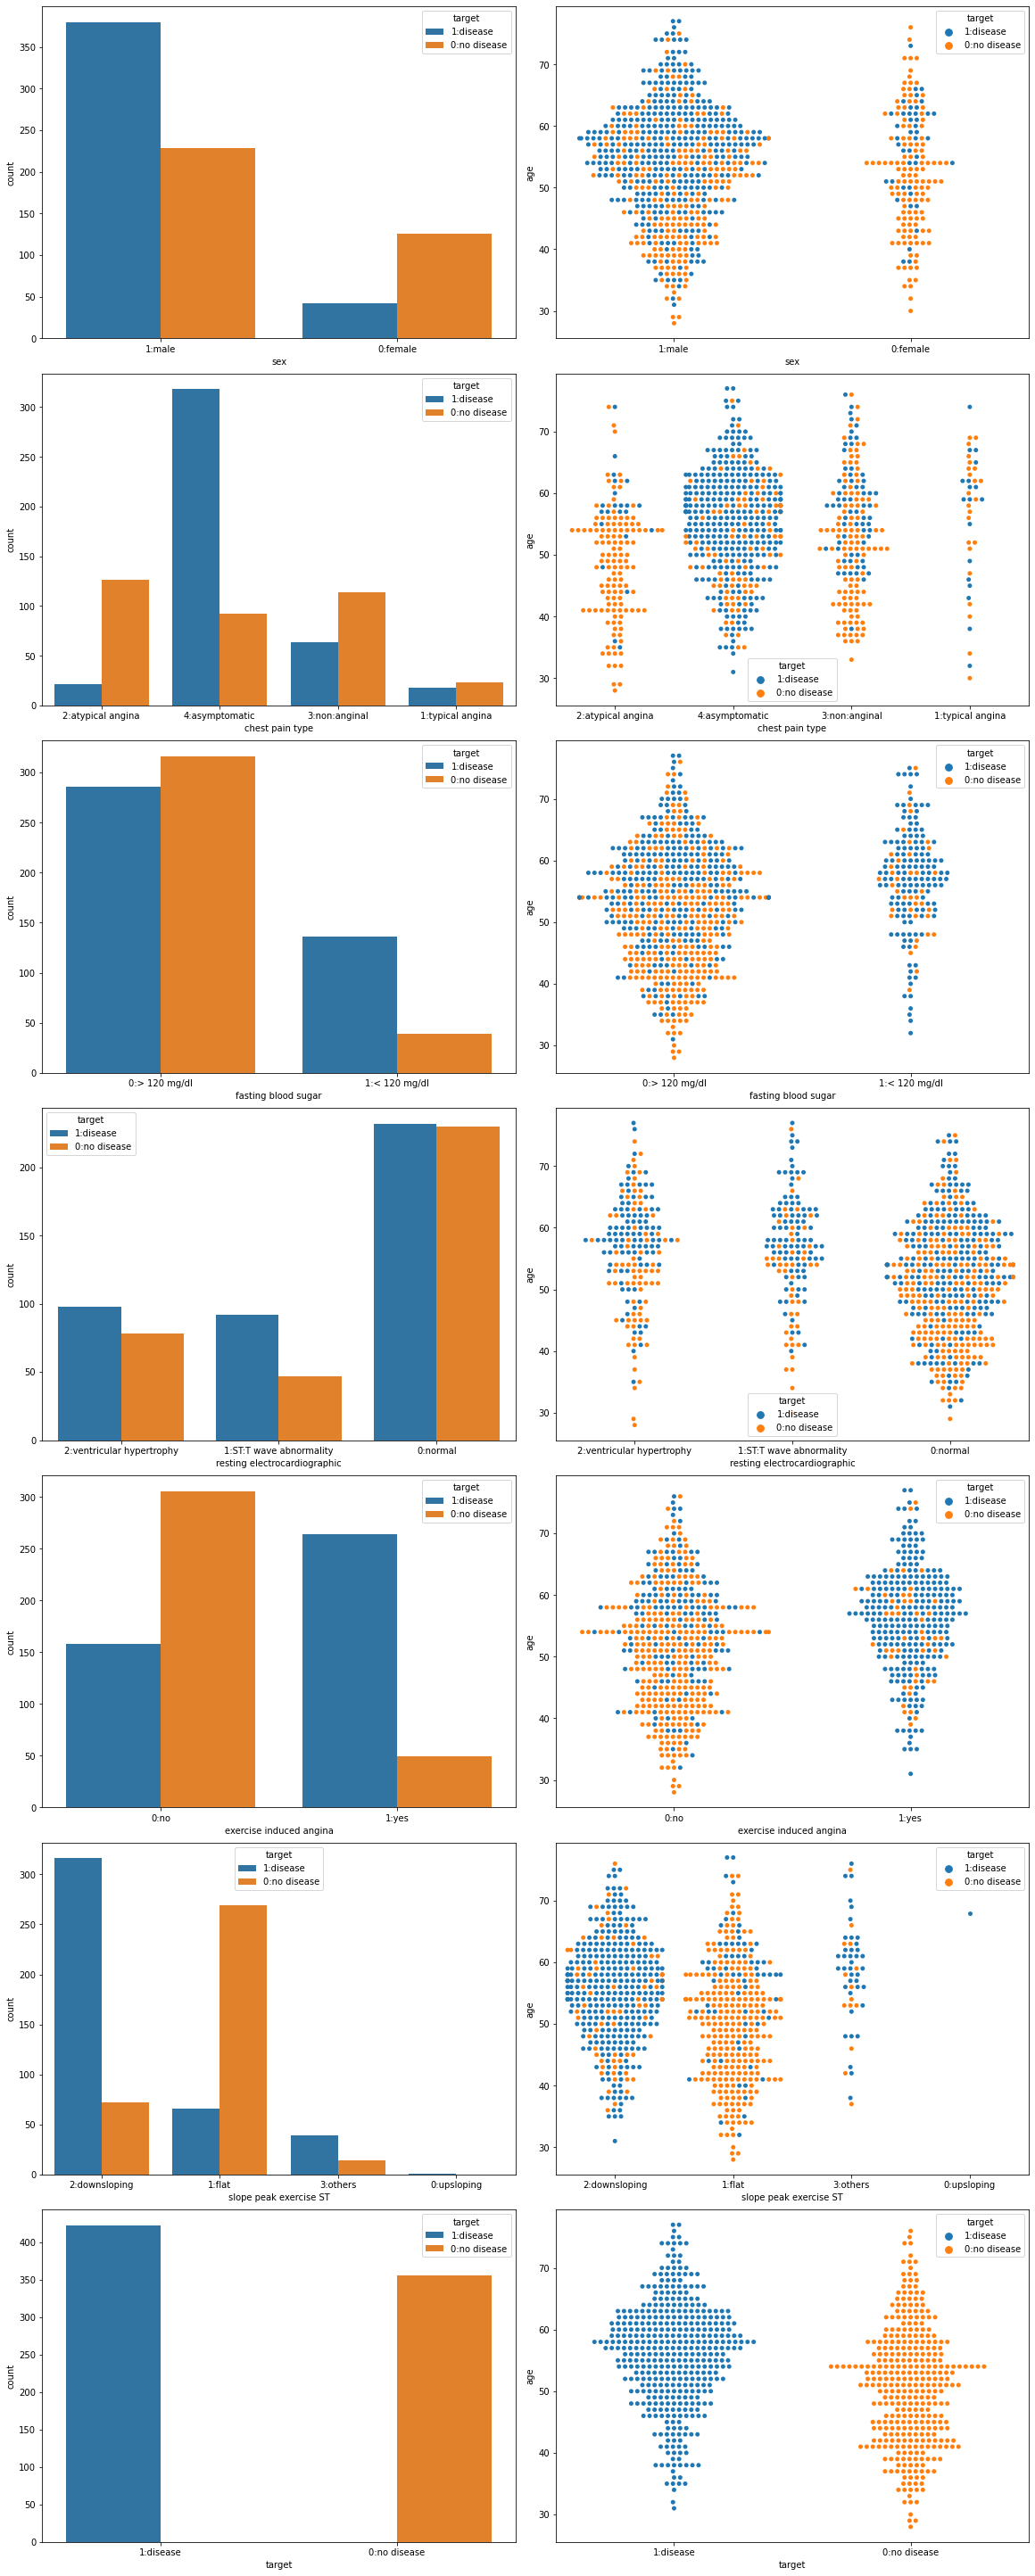

In [16]:
def plot_count_swarm_var():
    sub_num_of_row = len(cat_cols)
    sub_num_of_col = 2     # three columns: overall, no disease, disease

    _, axs = plt.subplots(nrows=sub_num_of_row, ncols=sub_num_of_col, figsize=(16, 40), constrained_layout = True)


    for i in range(sub_num_of_row):
        sns.countplot(data=cat_data, x=cat_cols[i], hue='target', ax=axs[i][0])
        sns.swarmplot(data=cat_data, x=cat_cols[i], y='age', hue='target', ax=axs[i][1])

plot_count_swarm_var()

### Plot - numerical data

In [17]:
numeric_data = train_data[num_cols]
num_disease = numeric_data[data_w_cat_vals['target'] == '1:disease']
num_no_disease = numeric_data[data_w_cat_vals['target'] == '0:no disease']

desired_data = {
    0: {"title":"DISEASE, target = 1", "data":num_disease},
    1: {"title":"NO DISEASE, target = 0", "data":num_no_disease},
    2: {"title":"Overall - {}", "data":numeric_data},
}


#### Plotting - Histogram

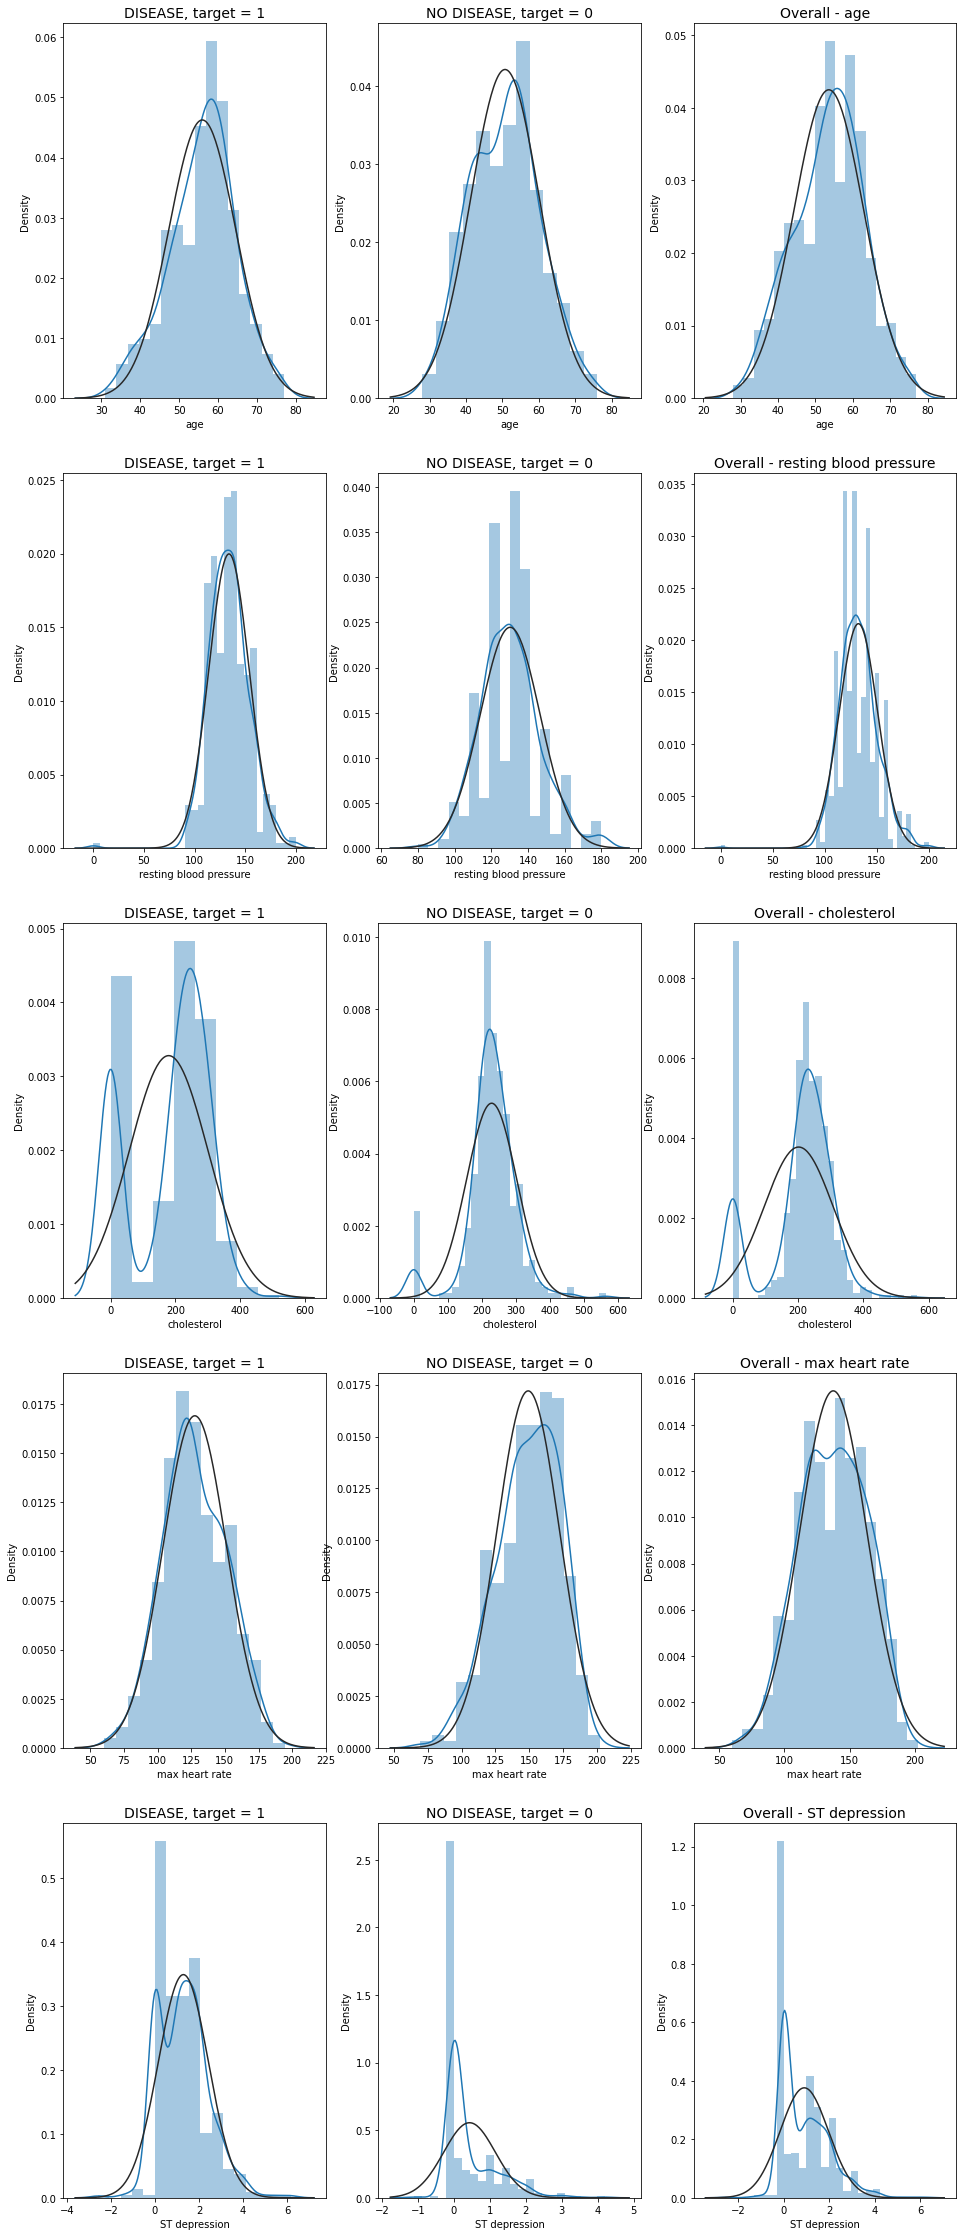

In [38]:


def plot_hist_num():
    sub_num_of_row = len(num_cols)
    sub_num_of_col = 3     # three columns: overall, no disease, disease

    _, axs = plt.subplots(nrows=sub_num_of_row, ncols=sub_num_of_col, figsize=(16,40),)


    for i in range(sub_num_of_row):
        for j in range(sub_num_of_col):
            graph = sns.distplot(desired_data[j].get('data')[num_cols[i]], fit=norm, ax=axs[i][j])
            graph.set_title(desired_data[j].get('title').format(num_cols[i]), fontsize=14)
            graph.set_xlabel(num_cols[i])

plot_hist_num()


#### Plotting - Box

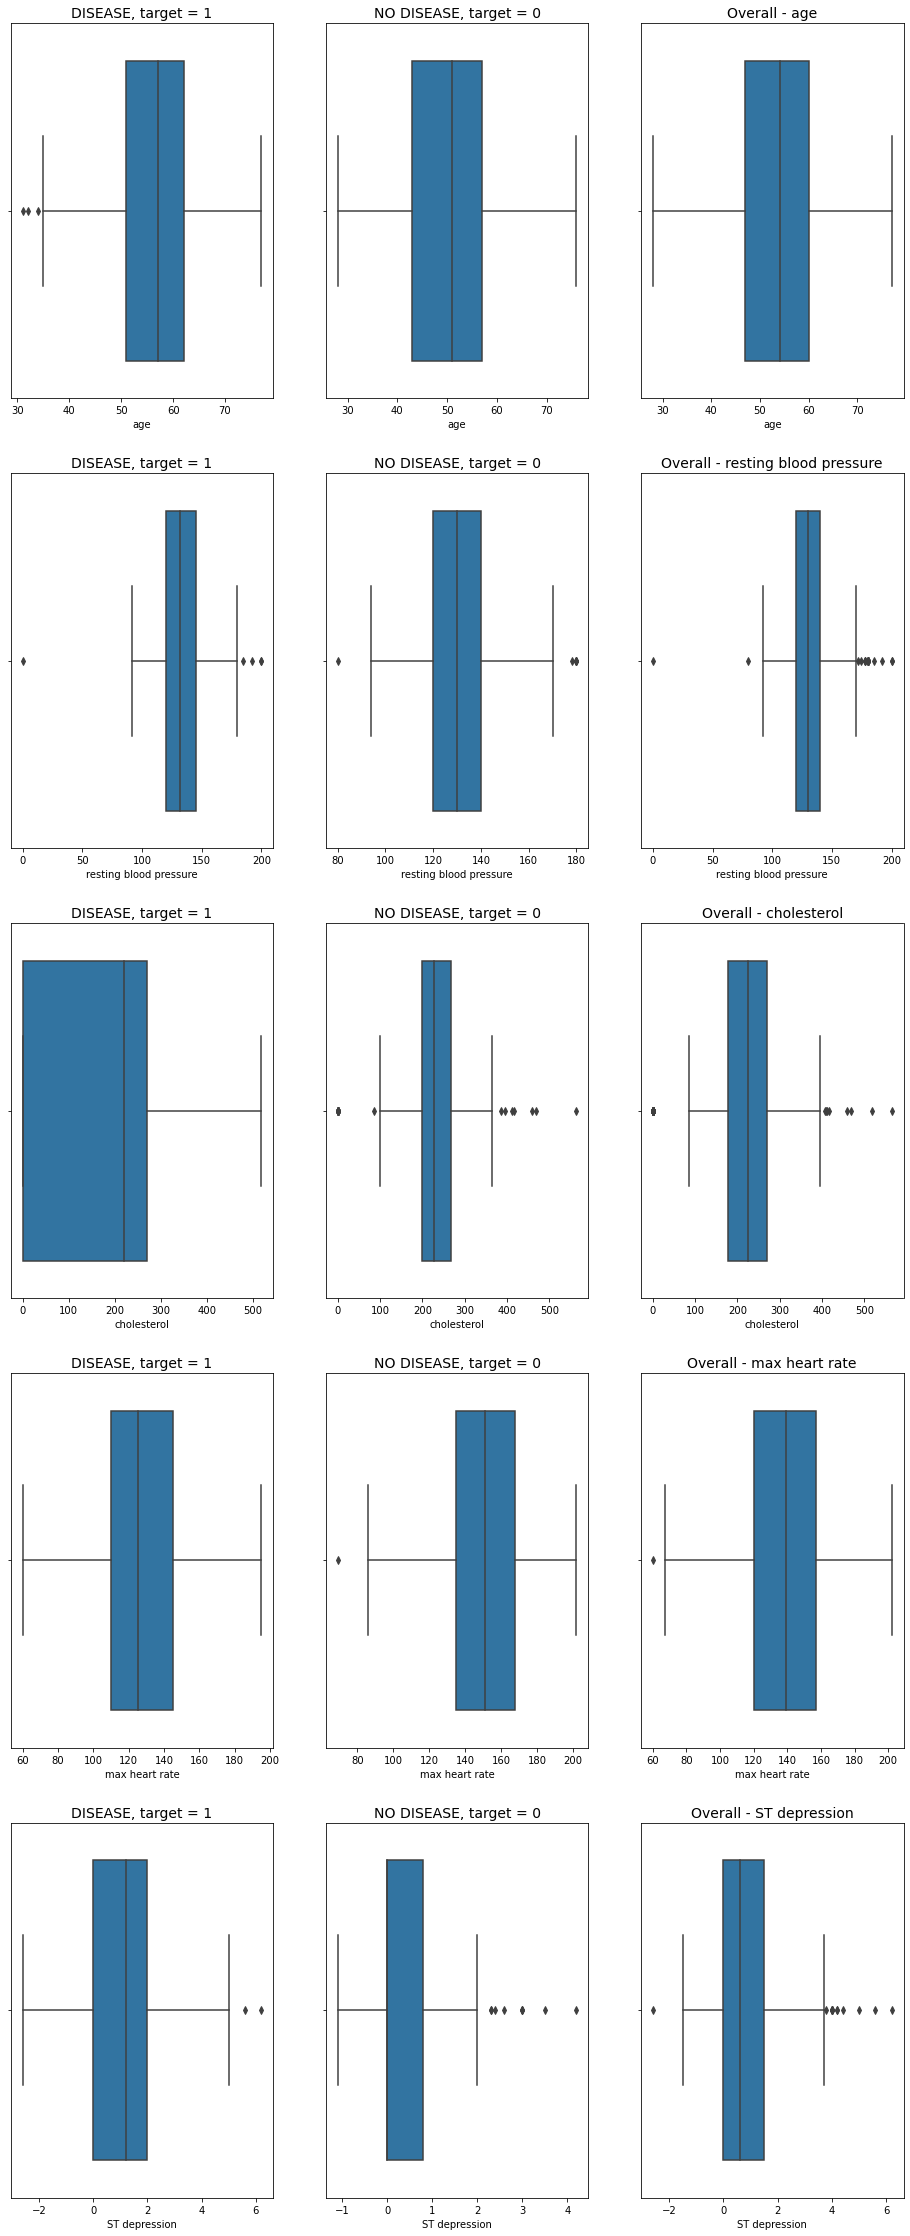

In [19]:
def plot_box_num():
    sub_num_of_row = len(num_cols)
    sub_num_of_col = 3     # three columns: overall, no disease, disease

    _, axs = plt.subplots(nrows=sub_num_of_row, ncols=sub_num_of_col, figsize=(16,40),)


    for i in range(sub_num_of_row):
        for j in range(sub_num_of_col):
            graph = sns.boxplot(desired_data[j].get('data')[num_cols[i]], ax=axs[i][j])
            graph.set_title(desired_data[j].get('title').format(num_cols[i]), fontsize=14)
            graph.set_xlabel(num_cols[i])

plot_box_num()


#### Plotting - Pairplot

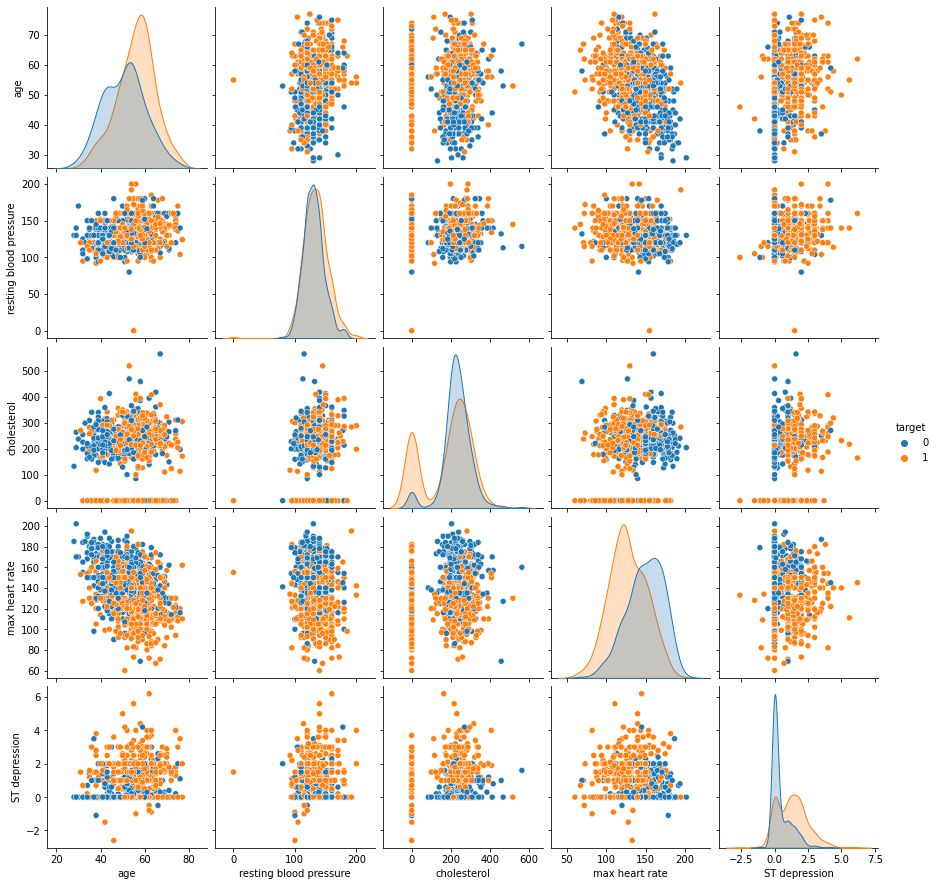

In [20]:
numeric_data_target = pd.concat([numeric_data, train_data['target']], axis=1)
sns.pairplot(data=numeric_data_target, hue='target')

# Feature engineering

## Selection

### Filter methods
The current problem contains independent features with categorical target. <br>
Therefore the desired filter methods to be used are **Chi2** and **LDA**:
1. For measuring the independence between Continues features and categorical target, The LDA algorithm should be used because:
    - LDA: Linear discriminant analysis is used to find a linear combination of features that characterizes or separates two or more classes (or levels) of a categorical variable.

2. For measuring the independence between categorical features and categorical target, The chi2 test should be used because:
    - Chi-Square: It is a is a statistical test applied to the groups of categorical features to evaluate the likelihood of correlation or association between them using their frequency distribution.

#### Multicollinearity Detecting
Variable Inflation Factors (VIF):
- VIF starts at 1 and has no upper limit
- VIF = 1, no correlation between the independent variable and the other variables
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In conclusion, No multicollinearity found between numeric features

##### Heatmap 

<AxesSubplot:>

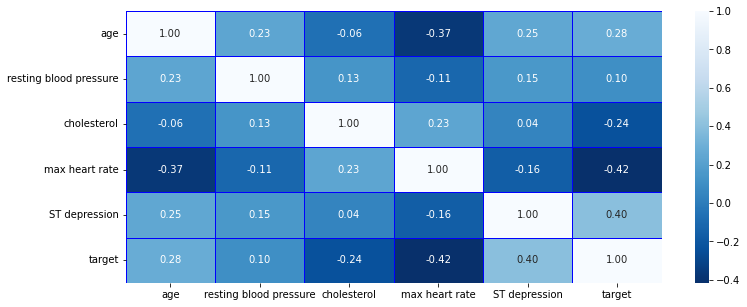

In [103]:
corr_values = train_data[num_cols+['target']].corr()
plt.figure(figsize=(12,5))
sns.heatmap(corr_values, linecolor='b', linewidths=1, annot=True, fmt='.2f', cmap = 'Blues_r')

In [104]:
vif = pd.DataFrame()
vif_corr_values = train_data[num_cols].corr()
vif["variables"] = vif_corr_values.columns
vif["VIF"] = [variance_inflation_factor(vif_corr_values.values, i) for i in range(vif_corr_values.shape[1])]
vif

,variables,VIF
0,age,2.27
1,resting blood pressure,1.43
2,cholesterol,1.41
3,max heart rate,2.18
4,ST depression,1.39


In [105]:
# # Find correlation for all features
# corr_values = corr_values.sort_values(by='target', ascending=False)['target'].to_frame()
# corr_values.drop(index='target', inplace=True)

# # Find correlation for all features in case of female gender 
# female_values = train_data[train_data['sex']==1][num_cols+['target']]
# female_corr_values = female_values.corr()
# female_corr_values = female_corr_values.sort_values(by='target', ascending=False)['target'].to_frame()
# female_corr_values.drop(index='target', inplace=True)


# # Find correlation for all features in case of male gender 
# male_values = train_data[train_data['sex']==0][num_cols+['target']]
# male_corr_values = male_values.corr()
# male_corr_values = male_corr_values.sort_values(by='target', ascending=False)['target'].to_frame()
# male_corr_values.drop(index='target', inplace=True)

# def plot_corr():

#     titles = (
#         'Heart Disease - CORRELATION, Overall',
#         'Heart Disease - CORRELATION, Female',
#         'Heart Disease - CORRELATION, Male',
#     )

#     corr_data = (corr_values, female_corr_values, male_corr_values)

#     _, axs = plt.subplots(nrows=1, ncols=3, figsize=(30,15))

#     for ind, ax in enumerate(axs):
#         sns.barplot(data=corr_data[ind], x='target', y=corr_data[ind].index, ax=ax)
#         for patch in ax.patches:
#             ax.annotate("%.4f"% patch.get_width(), (patch.get_x() + patch.get_width(), patch.get_y()))
#         ax.set_title(titles[ind], fontsize=20)

#         ax.set_xticks([-0.4, 1])

# plot_corr() 


In [106]:
@dataclasses.dataclass
class TestResult:
    specs: List[str]
    scores: List[Union[int, float]]
    p_values: List[Union[int, float]]



def feat_imp_plot(test_res:TestResult, title):
    """Plotting feature importance as bar"""

    # Grouping results in DataFrame
    result = pd.DataFrame()
    result['Specs'] = test_res.specs
    result['Score'] = test_res.scores
    result['P-values'] = test_res.p_values
    result = result.sort_values(by='Score', ascending=False)
    plt.figure(figsize=(20,5))
    sns.barplot(x='Specs', y='Score', data=result, palette = "GnBu_d")
    plt.box(False)
    plt.title(title, fontsize=16)
    plt.xlabel('\n Features', fontsize=14)
    plt.ylabel('Importance \n', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)


#### Chi2 Test
Depending on the p_values and the previous categorical features plots we conclude.<br>
The following features demonstrate significant difference that help in distinguishing CAD diseases:
- exercise induced angina
- slope peak exercise ST
- chest pain type
- fasting blood sugar


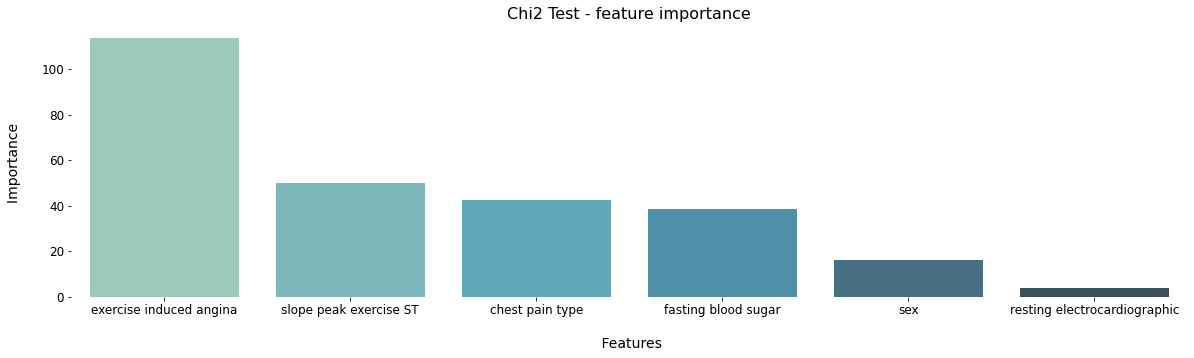

In [107]:
chi2_stats, p_values = chi2(train_data[cat_cols[:-1]], train_data['target'])
feat_imp_plot(TestResult(cat_cols[:-1], chi2_stats, p_values), 'Chi2 Test - feature importance')

#### ANOVA Test
Depending on the p_values and the previous numerical features plots we conclude.<br>
The following features demonstrate significant difference that help in distinguishing CAD diseases:
- max heart rate
- ST depression
- age
- cholesterol


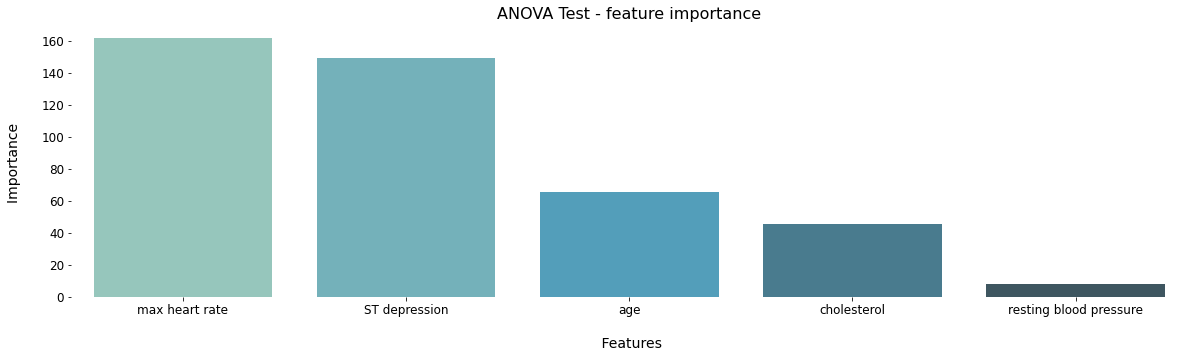

In [108]:
f_stats, p_values = f_classif(train_data[num_cols], train_data['target'])
feat_imp_plot(TestResult(num_cols, f_stats, p_values), 'ANOVA Test - feature importance')

#### LDA Test

In [109]:
lda_X = train_data[num_cols]
lda_y = train_data['target']

lda = SelectFromModel(LinearDiscriminantAnalysis()).fit(lda_X, lda_y)


#### Elimination

In [110]:
anova_feat = np.array(num_cols)[SelectKBest(f_classif, k=3).fit(anova_X, anova_y).get_support()].tolist()
chi2_feat = np.array(cat_cols[:-1])[SelectKBest(chi2, k=4).fit(chi2_X, chi2_y).get_support()].tolist()
lda_feat = np.array(num_cols)[lda.get_support()].tolist()

filter_important_feat = np.array(chi2_feat + anova_feat)
filter_important_feat


array(['chest pain type', 'fasting blood sugar',
       'exercise induced angina', 'slope peak exercise ST', 'age',
       'max heart rate', 'ST depression'], dtype='<U23')

### Wrapper methods

#### RFE

In [111]:
rfe_X, rfe_y = train_data.iloc[:,:-1], train_data['target']

svc_model = SVC(kernel='linear')
rfe = RFE(svc_model, n_features_to_select=7, step=1).fit(rfe_X, rfe_y)
wrapper_important_feat = np.array(train_data.columns[:-1])[rfe.get_support()]


In [112]:
wrapper_important_feat

array(['sex', 'chest pain type', 'fasting blood sugar',
       'resting electrocardiographic', 'exercise induced angina',
       'ST depression', 'slope peak exercise ST'], dtype=object)

In [113]:
important_features = np.intersect1d(filter_important_feat, wrapper_important_feat).tolist()

### Important Features

In [114]:
selected_train_data = train_data[important_features + ['target']] 
selected_test_data = test_data[important_features + ['target']] 

## Scaling
Normalizing features helps to increase model's accuracy

In [115]:
norm_scaler = MinMaxScaler()
scaled_train_data = norm_scaler.fit_transform(selected_train_data.iloc[:,:])
scaled_test_data = norm_scaler.transform(selected_test_data.iloc[:,:])


# Train/Test Split

In [116]:
X_train = scaled_train_data[:,:-1]
y_train = scaled_train_data[:,-1]
X_test = scaled_test_data[:,:-1]
y_test = scaled_test_data[:,-1]

print ('Train set:  ', X_train.shape,  y_train.shape)
print ('Test set:   ', X_test.shape,  y_test.shape)

Train set:   (777, 5) (777,)
Test set:    (238, 5) (238,)


# Model building

## Model Evaluation

In [117]:
class Report:
    def __init__(self, estimator, X_train, y_train, X_test, y_test):
        self.estimator = estimator
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    def calc_cross_val(self):
        acc = cross_val_score(self.estimator, self.X_train, self.y_train, cv=10, scoring='accuracy').mean()
        print('Cross Validation Score (mean):  {:3.4%}'.format(acc))

    def calc_acc_val(self):   
        self.estimator.fit(self.X_train, self.y_train)
        print('Train accuracy Score:  {:3.4%}'.format(self.estimator.score(self.X_train, self.y_train)))
        print('Test accuracy Score:  {:3.4%}'.format(self.estimator.score(self.X_test, self.y_test)))

    def report_confusion(self):
        print(classification_report(self.y_test, self.estimator.predict(self.X_test)))

        _, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
        plot_confusion_matrix(self.estimator, self.X_test, self.y_test, ax=axs[0])
        plot_confusion_matrix(self.estimator, self.X_train, self.y_train, ax=axs[1])
        axs[0].set_title('Test')
        axs[1].set_title('Train')
        plt.tight_layout()

    def roc_curve(self):
        plot_roc_curve(self.estimator, self.X_test, self.y_test)
        plt.plot([0,1],[0,1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')


    def get_report(self):
        self.calc_cross_val()
        self.calc_acc_val()
        self.report_confusion()
        self.roc_curve()



## Decision Tree

Cross Validation Score (mean):  80.8358%
Train accuracy Score:  91.3771%
Test accuracy Score:  84.8739%
              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84       108
         1.0       0.88      0.84      0.86       130

    accuracy                           0.85       238
   macro avg       0.85      0.85      0.85       238
weighted avg       0.85      0.85      0.85       238



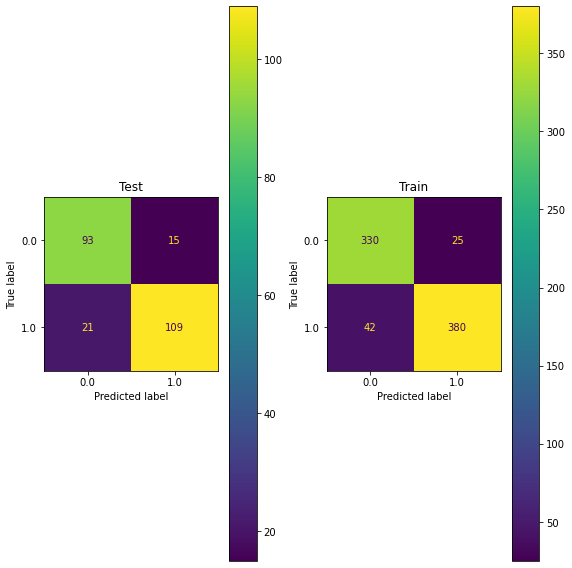

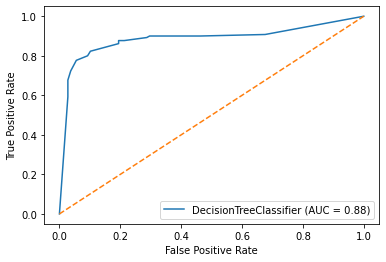

In [118]:
dt_model = DecisionTreeClassifier()
Report(dt_model, X_train, y_train, X_test, y_test).get_report()

Cross Validation Score (mean):  82.8871%
Train accuracy Score:  90.2188%
Test accuracy Score:  85.7143%
              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84       108
         1.0       0.86      0.88      0.87       130

    accuracy                           0.86       238
   macro avg       0.86      0.86      0.86       238
weighted avg       0.86      0.86      0.86       238



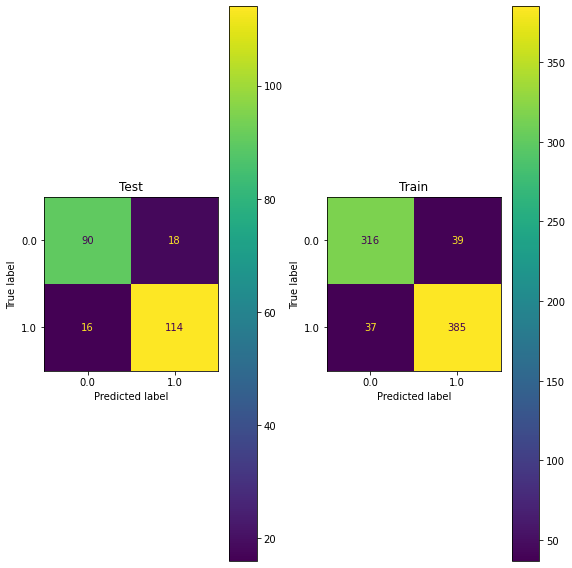

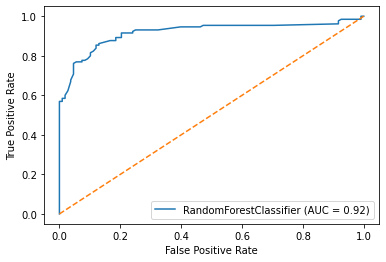

In [119]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=8)
Report(rf_model, X_train, y_train, X_test, y_test).get_report()